<a href="https://colab.research.google.com/github/AharonRemez/Emotion-Classification-Using-Convolutional-Neural-Networks-CNN-1/blob/main/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download the Dataset**

**Dataset Download and Extraction:**

In [1]:
!pip install kaggle
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
!unzip emotion-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: dataset/Sad/0a1d86074a08f9bf55858cf90eaaee6f1e0362d97f08cbaa161e30e0.jpg  
  inflating: dataset/Sad/0a22b8d3b2fbcbebb6a4be7dad0a37b92983e8afe42b4d48cded4e45.jpg  
  inflating: dataset/Sad/0a285a2a07f0f8daaa0a821e30ad2e558ddc18f2589a

# **Rest of code**

**Library Imports:**

In [2]:
import numpy as np
import PIL
import tensorflow as tf
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Dataset Path Initialization and Class Name Extraction:**

In [3]:
data_dir = Path('/content/dataset')
CLASS_NAMES = []

x = 0  # Initialize counter for total images
for expression in os.listdir(data_dir):
    # Create path to each expression folder
    expression_path = data_dir / expression
    print(f'{expression}\t=> {len(os.listdir(expression_path))} images')  # Print count of images per class
    x += len(os.listdir(expression_path))  # Increment total image counter
    CLASS_NAMES.append(expression)

print(f'Total Images: {x}')
print(f'Class Names: {CLASS_NAMES}')

Neutral	=> 4027 images
Happy	=> 3740 images
Angry	=> 1313 images
Surprise	=> 1234 images
Sad	=> 3934 images
Ahegao	=> 1205 images
Total Images: 15453
Class Names: ['Neutral', 'Happy', 'Angry', 'Surprise', 'Sad', 'Ahegao']


**Delete the Ahegao folder from the dataset for me:**

In [4]:
!rm -rf /content/dataset/Ahegao

**Dataset Preparation and Splitting for Training and Validation:**

In [6]:
CONFIGURATION = {
    'VALIDATION': 0.2,
    'BATCH_SIZE': 64,
    'IM_SIZE': 224,
    'LEARNING_RATE': 1e-3,
    'N_EPOCHS': 50,
    'DROPOUT_RATE': 0.25,
    'REGULARIZATION_RATE': 0.01,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 5,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 128,
    'N_DENSE_2': 32,
    'NUM_CLASSES': len(CLASS_NAMES),
    'CLASS_NAMES': CLASS_NAMES,
}

# Ensure that CLASS_NAMES in CONFIGURATION matches the current subdirectories
# This will update CLASS_NAMES to reflect the current state of the data_dir
CONFIGURATION['CLASS_NAMES'] = sorted(os.listdir(data_dir))
CONFIGURATION['NUM_CLASSES'] = len(CONFIGURATION['CLASS_NAMES']) # update num classes

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'], # Use updated CLASS_NAMES
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=100,
    subset="training",
    validation_split=CONFIGURATION['VALIDATION']
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'], # Use updated CLASS_NAMES
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=200,
    subset="validation",
    validation_split=CONFIGURATION['VALIDATION']
)

Found 14248 files belonging to 5 classes.
Using 11399 files for training.
Found 14248 files belonging to 5 classes.
Using 2849 files for validation.


**Check the class names:**

In [7]:
class_names = train_ds.class_names
print(class_names)

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


**Batch Inspection:**

In [8]:
for image_batch, labels_batch in train_ds:
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break

Image batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 5)


**Dataset Caching and Prefetching:**

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Model Definition - EfficientNetV2B0 Backbone:**

In [10]:
backbone = tf.keras.applications.EfficientNetV2B0(
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
    include_top=False,
    weights='imagenet'
)
backbone.trainable = False  # Freeze the backbone layers

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Model Construction:**

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Prevent overfitting
    tf.keras.layers.Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')  # Output layer
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │         313,605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,232,917 (23.78 MB)

 Trainable params: 313,605 (1.20 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

**Model Compilation and Training with Early Stopping and Checkpointing:**

In [13]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


loss_func = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'accuracy')]

checkpoint_callback = ModelCheckpoint(
    'best_weights.keras',  # Save the best model weights
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True  # Only save the best weights
)

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy for early stopping
    restore_best_weights=True,  # Restore the best weights when stopping
    patience=3  # Number of epochs to wait before stopping if no improvement
)

model.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss=loss_func,
    metrics=metrics
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIGURATION['N_EPOCHS'],  # Number of epochs
    verbose=1,  # Verbosity level for logging
    callbacks=[early_stopping]
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 225ms/step - accuracy: 0.4904 - loss: 21.6322 - val_accuracy: 0.7420 - val_loss: 9.1504
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.6875 - loss: 13.9558 - val_accuracy: 0.7859 - val_loss: 8.2754
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7404 - loss: 13.1496 - val_accuracy: 0.8326 - val_loss: 7.3309
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7677 - loss: 11.9074 - val_accuracy: 0.8291 - val_loss: 8.5289
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7960 - loss: 11.7272 - val_accuracy: 0.8754 - val_loss: 6.6469
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8075 - loss: 11.0456 - val_accuracy: 0.8789 - val_loss: 7.2418
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.8244 - loss: 10.8059 - val_accuracy: 0.8880 - val_loss: 6.7140
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.8389 - loss: 1

**Display Sample Images with Predictions:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


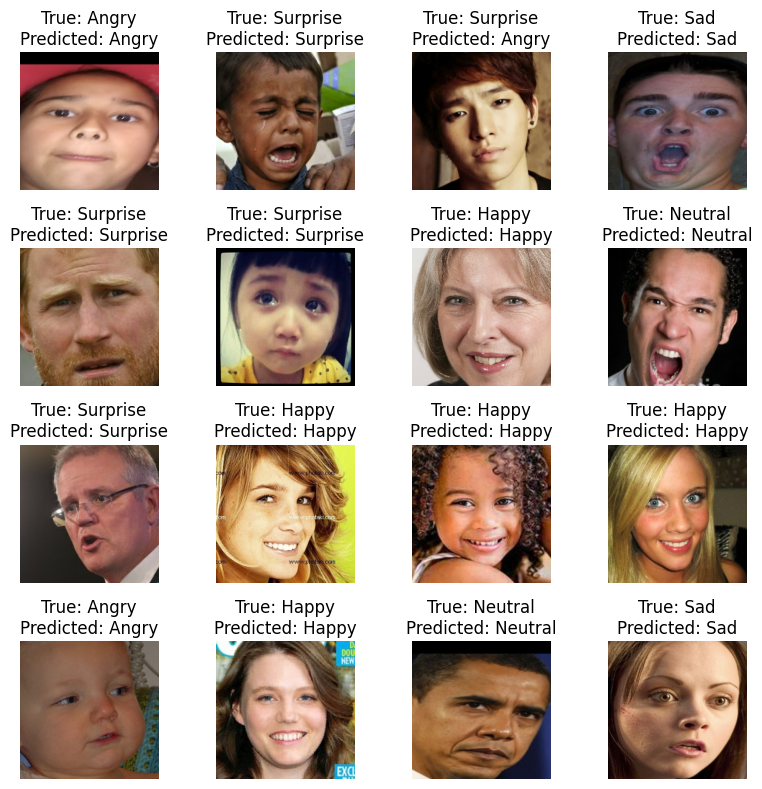

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for image_batch, label_batch in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i] / 255)
        true_label = CLASS_NAMES[tf.argmax(label_batch[i], axis=0).numpy()]
        predicted_label = CLASS_NAMES[tf.argmax(model.predict(tf.expand_dims(image_batch[i], axis=0)), axis=1).numpy()[0]]
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
        plt.axis('off')  # Remove axis
    plt.tight_layout()
    plt.show()

**Display Confusion Matrix:**

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━

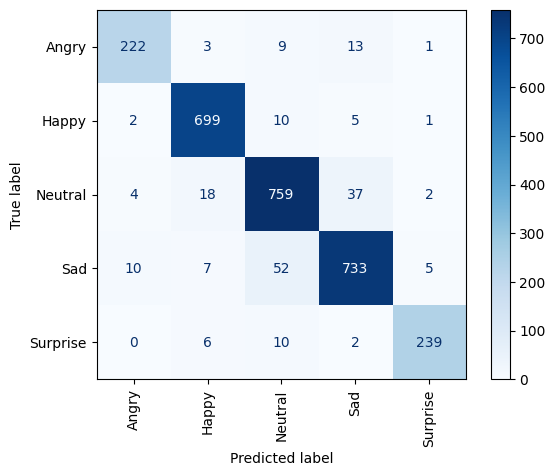

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop through the validation dataset and generate predictions
for images, labels in val_ds:
    predictions = model.predict(images)
    for i in range(images.shape[0]):
        y_true.append(np.argmax(labels[i]))
        y_pred.append(np.argmax(predictions[i]))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


**Single Image Prediction from User Upload:**

Saving sad-man.jpg to sad-man.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This image most likely belongs to Sad with a 40.46 percent confidence.


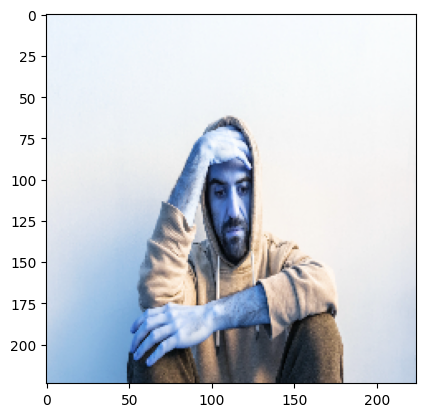

In [19]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# Upload an image file
uploaded = files.upload()

# Loop through each uploaded file and predict the image class
for fn in uploaded.keys():
    path = '/content/' + fn
    # Check if the file is an image
    if fn.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(path)
        # Check if image loaded successfully
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize image to model input size
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create a batch

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            print(
                "This image most likely belongs to {} with a {:.2f} percent confidence."
                .format(class_names[np.argmax(score)], 100 * np.max(score))
            )
            plt.imshow(img)
            plt.show()
        else:
            print(f"Error: Could not load image from {path}. Check if the file exists and is a valid image.")
    else:
        print(f"Error: {fn} is not a supported image file. Please upload a .png, .jpg, or .jpeg file.")